In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm
import matplotlib.gridspec as gridspec

sys.path.append('../funcs')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = "../data/raw/proteomics/"
OUT_DIR = "../data/processed/061721_tumor_normals"
PLOTS_DIR = "figures/data_processing_tumor_normal"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"
SUBSET_LOCALIZED_SITES = True
KNN_NEIGHBORS = 5

In [3]:
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

os.makedirs(os.path.join(OUT_DIR, "raw"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "nafilt"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed_res"), exist_ok=True)

## 1. Loading Info from Raw `.gct` Files

`accessionNumber_VMsites_numVMsitesPresent_numVMsitesLocalizedBest_earliestVMsiteAA_latestVMsiteAA`

---

In [4]:
gct = {}

for x in glob.glob(os.path.join(DATA_DIR,'*')):
    if os.path.isdir(x):
        cohort = os.path.basename(x).upper()
        cohort_gct = {}
        print("   * Loading {} ...".format(cohort))
        
        for filepath in glob.glob(os.path.join(x,"*.gct")):
            g = prot.GCT(filepath)
            
            if SUBSET_LOCALIZED_SITES:
                if g.assay in ('acetylome','phosphoproteome'):
                    _prev = g.n_var
                    feats_to_keep = g.var_names[[x.split("_")[3]==x.split("_")[4] for x in g.var_names]]
                    g.subset(var=feats_to_keep)
                    print("     * {} | {}/{} ({:,.2f}%) fully localized sites".format(g.assay, g.n_var, _prev, 100*g.n_var/_prev))
                
            cohort_gct[g.assay] = g
 
        gct[cohort] = cohort_gct

   * Loading COAD ...
     * phosphoproteome | 25635/36657 (69.93%) fully localized sites
   * Loading MEDUL ...
     * acetylome | 9910/10024 (98.86%) fully localized sites
     * phosphoproteome | 33332/50191 (66.41%) fully localized sites
   * Loading UCEC ...
     * acetylome | 9821/9976 (98.45%) fully localized sites
     * phosphoproteome | 42846/60287 (71.07%) fully localized sites
   * Loading LUAD ...
     * phosphoproteome | 46078/65032 (70.85%) fully localized sites
     * acetylome | 13196/13371 (98.69%) fully localized sites
   * Loading HNSCC ...
     * phosphoproteome | 40048/55270 (72.46%) fully localized sites
   * Loading PDAC ...
     * phosphoproteome | 34676/47793 (72.55%) fully localized sites
   * Loading CCRCC ...
     * phosphoproteome | 40549/56425 (71.86%) fully localized sites
   * Loading BRCA ...
     * acetylome | 19538/19738 (98.99%) fully localized sites
     * phosphoproteome | 43781/62584 (69.96%) fully localized sites
   * Loading GBM ...
     * acet

In [5]:
prot.parse_participant_and_type(gct,'proteome')
prot.parse_participant_and_type(gct,'phosphoproteome')
prot.parse_participant_and_type(gct,'acetylome')

In [6]:
prot_df = pd.concat([gct[cohort]['proteome'].obs for cohort in gct.keys()])
phosph_df = pd.concat([gct[cohort]['phosphoproteome'].obs for cohort in gct.keys()])
acetyl_df = pd.concat([gct[cohort]['acetylome'].obs for cohort in ['BRCA','GBM','LSCC','LUAD','UCEC','MEDUL']])

## 2. Load Participant Dataframe


Curated by Yo Akiyama.

---

In [7]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)
samples_df.head()

cohort Proteome_Sample_ID Proteome_Normal_Sample_ID  \
participant_id                                                       
CPT000814        BRCA          CPT000814                       NaN   
CPT001846        BRCA          CPT001846                       NaN   
01BR001          BRCA           X01BR001                       NaN   
01BR008          BRCA           X01BR008                       NaN   
01BR009          BRCA           X01BR009                       NaN   

               Phosphoproteome_Sample_ID Phosphoproteome_Normal_Sample_ID  \
participant_id                                                              
CPT000814                      CPT000814                              NaN   
CPT001846                      CPT001846                              NaN   
01BR001                         X01BR001                              NaN   
01BR008                         X01BR008                              NaN   
01BR009                         X01BR009                              NaN   

               Acetylome_Sample_ID Acetylome_Normal_Sample_ID RNA_Tumor  \
participant_id                                                            
CPT000814                CPT000814                        NaN     334_R   
CPT001846                CPT001846                        NaN     340_R   
01BR001                   X01BR001                        NaN      25-R   
01BR008                   X01BR008                        NaN     350-R   
01BR009                   X01BR009                        NaN     345-R   

               RNA_Normal Germline_WGS        WXS  
participant_id                                     
CPT000814             NaN          NaN      604_T  
CPT001846             NaN          NaN  01BR044_T  
01BR001               NaN          NaN  01BR001_T  
01BR008               NaN          NaN  01BR008_T  
01BR009               NaN          NaN  01BR009_T

In [8]:
# samples_df = pd.read_csv(os.path.join(DATA_DIR,'PanCan_sample_table_2021.txt'), sep='\t', index_col=0)
# samples_df.columns=['cohort']
# samples_df.groupby('cohort').size()

# cohort_naming = {x:('COAD' if x=='CO' else x.upper()) for x in np.unique(samples_df['cohort'])}
# samples_df['cohort_x'] = samples_df['cohort'].apply(lambda x: cohort_naming[x])

# samples_df = samples_df.reset_index().drop_duplicates().set_index('Sample_ID')
# samples_df.index.name = "Participant_ID"

# # Proteome
# samples_df = samples_df.join(subset_pdf(prot_df[~prot_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Tumor','Proteome'))
# samples_df = samples_df.join(subset_pdf(prot_df[prot_df.index.str.endswith(("REP1",".1"))],'Tumor','Proteome_2'))
# samples_df = samples_df.join(subset_pdf(prot_df[prot_df.index.str.endswith(("REP2",".2"))],'Tumor','Proteome_3'))
# samples_df = samples_df.join(subset_pdf(prot_df[prot_df.index.str.endswith((".3"))],'Tumor','Proteome_4'))

# samples_df = samples_df.join(subset_pdf(prot_df[~prot_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Normal','Proteome_Normal'))
# samples_df = samples_df.join(subset_pdf(prot_df[prot_df.index.str.endswith(("REP1",".1"))],'Normal','Proteome_Normal_2'))

# # Phosphoproteome
# samples_df = samples_df.join(subset_pdf(phosph_df[~phosph_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Tumor','Phosphoproteome'))
# samples_df = samples_df.join(subset_pdf(phosph_df[phosph_df.index.str.endswith(("REP1",".1"))],'Tumor','Phosphoproteome_2'))
# samples_df = samples_df.join(subset_pdf(phosph_df[phosph_df.index.str.endswith(("REP2",".2"))],'Tumor','Phosphoproteome_3'))
# samples_df = samples_df.join(subset_pdf(phosph_df[phosph_df.index.str.endswith((".3"))],'Tumor','Phosphoproteome_4'))

# samples_df = samples_df.join(subset_pdf(phosph_df[~phosph_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Normal','Phosphoproteome_Normal'))
# samples_df = samples_df.join(subset_pdf(phosph_df[phosph_df.index.str.endswith(("REP1",".1"))],'Normal','Phosphoproteome_Normal_2'))

# # Acetylome
# samples_df = samples_df.join(subset_pdf(acetyl_df[~acetyl_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Tumor','Acetylome'))
# samples_df = samples_df.join(subset_pdf(acetyl_df[acetyl_df.index.str.endswith(("REP1",".1"))],'Tumor','Acetylome_2'))
# samples_df = samples_df.join(subset_pdf(acetyl_df[acetyl_df.index.str.endswith(("REP2",".2"))],'Tumor','Acetylome_3'))

# samples_df = samples_df.join(subset_pdf(acetyl_df[~acetyl_df.index.str.endswith(("REP1",".1","REP2",".2",".3"))],'Normal','Acetylome_Normal'))
# samples_df.to_csv(os.path.join(OUT_DIR, "sample_map.tsv"),sep='\t')

In [9]:
prot_df.to_csv(os.path.join(OUT_DIR, "proteome_obs.tsv"),sep='\t')
phosph_df.to_csv(os.path.join(OUT_DIR, "phosphoproteome_obs.tsv"),sep='\t')
acetyl_df.to_csv(os.path.join(OUT_DIR, "acetylome_obs.tsv"),sep='\t')

## 3. Combine Matrices
---

In [10]:
def get_samples(samples_df, cohort, col):
    return samples_df[samples_df['cohort']==cohort][col].dropna()

In [11]:
assays = ('proteome','phosphoproteome','acetylome')

raw_data_files = {}
n_feats = {}
features_df = list()

for assay in assays:
    raw_data_files[assay] = {}
    n_feats[assay] = {}
    
    for cohort in gct.keys():
        if assay in gct[cohort]:
            raw_data_files[assay][cohort] = {}
            
            # Tumor
            raw_data_files[assay][cohort]['Tumor'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # Normal
            raw_data_files[assay][cohort]['Normal'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Normal_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # All
            _all_samples = list(get_samples(samples_df, cohort, '{}_Sample_ID'.format(assay.capitalize())).values) + list(get_samples(samples_df, cohort, '{}_Normal_Sample_ID'.format(assay.capitalize())).values)
            raw_data_files[assay][cohort]['All'] = gct[cohort][assay].X[_all_samples].dropna(axis=0,how='all').copy()
            
            # Stats
            n_feats[assay][cohort] = {}
            n_feats[assay][cohort]['Tumor'] = {}
            n_feats[assay][cohort]['Normal'] = {}

            n_feats[assay][cohort]['Tumor']['coverage'] = raw_data_files[assay][cohort]['Tumor'].shape[0]
            n_feats[assay][cohort]['Tumor']['samples'] = raw_data_files[assay][cohort]['Tumor'].shape[1]
            n_feats[assay][cohort]['Normal']['coverage'] = raw_data_files[assay][cohort]['Normal'].shape[0]
            n_feats[assay][cohort]['Normal']['samples'] = raw_data_files[assay][cohort]['Normal'].shape[1]
            
            # Features
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Tumor'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Tumor'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Normal'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Normal'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
features_df = pd.concat(features_df)

In [12]:
n_feats = pd.DataFrame.from_dict(n_feats)
full_feats_df = list()

for col in n_feats.columns:
    for row in n_feats.index:
        try:
            _df = pd.DataFrame.from_dict(n_feats.loc[row,col]).T.reset_index().rename(columns={'index':'Type'})
            _df['Assay'] = col
            _df['Cohort'] = row
            full_feats_df.append(_df)
        except:
            pass
        
full_feats_df = pd.concat(full_feats_df)

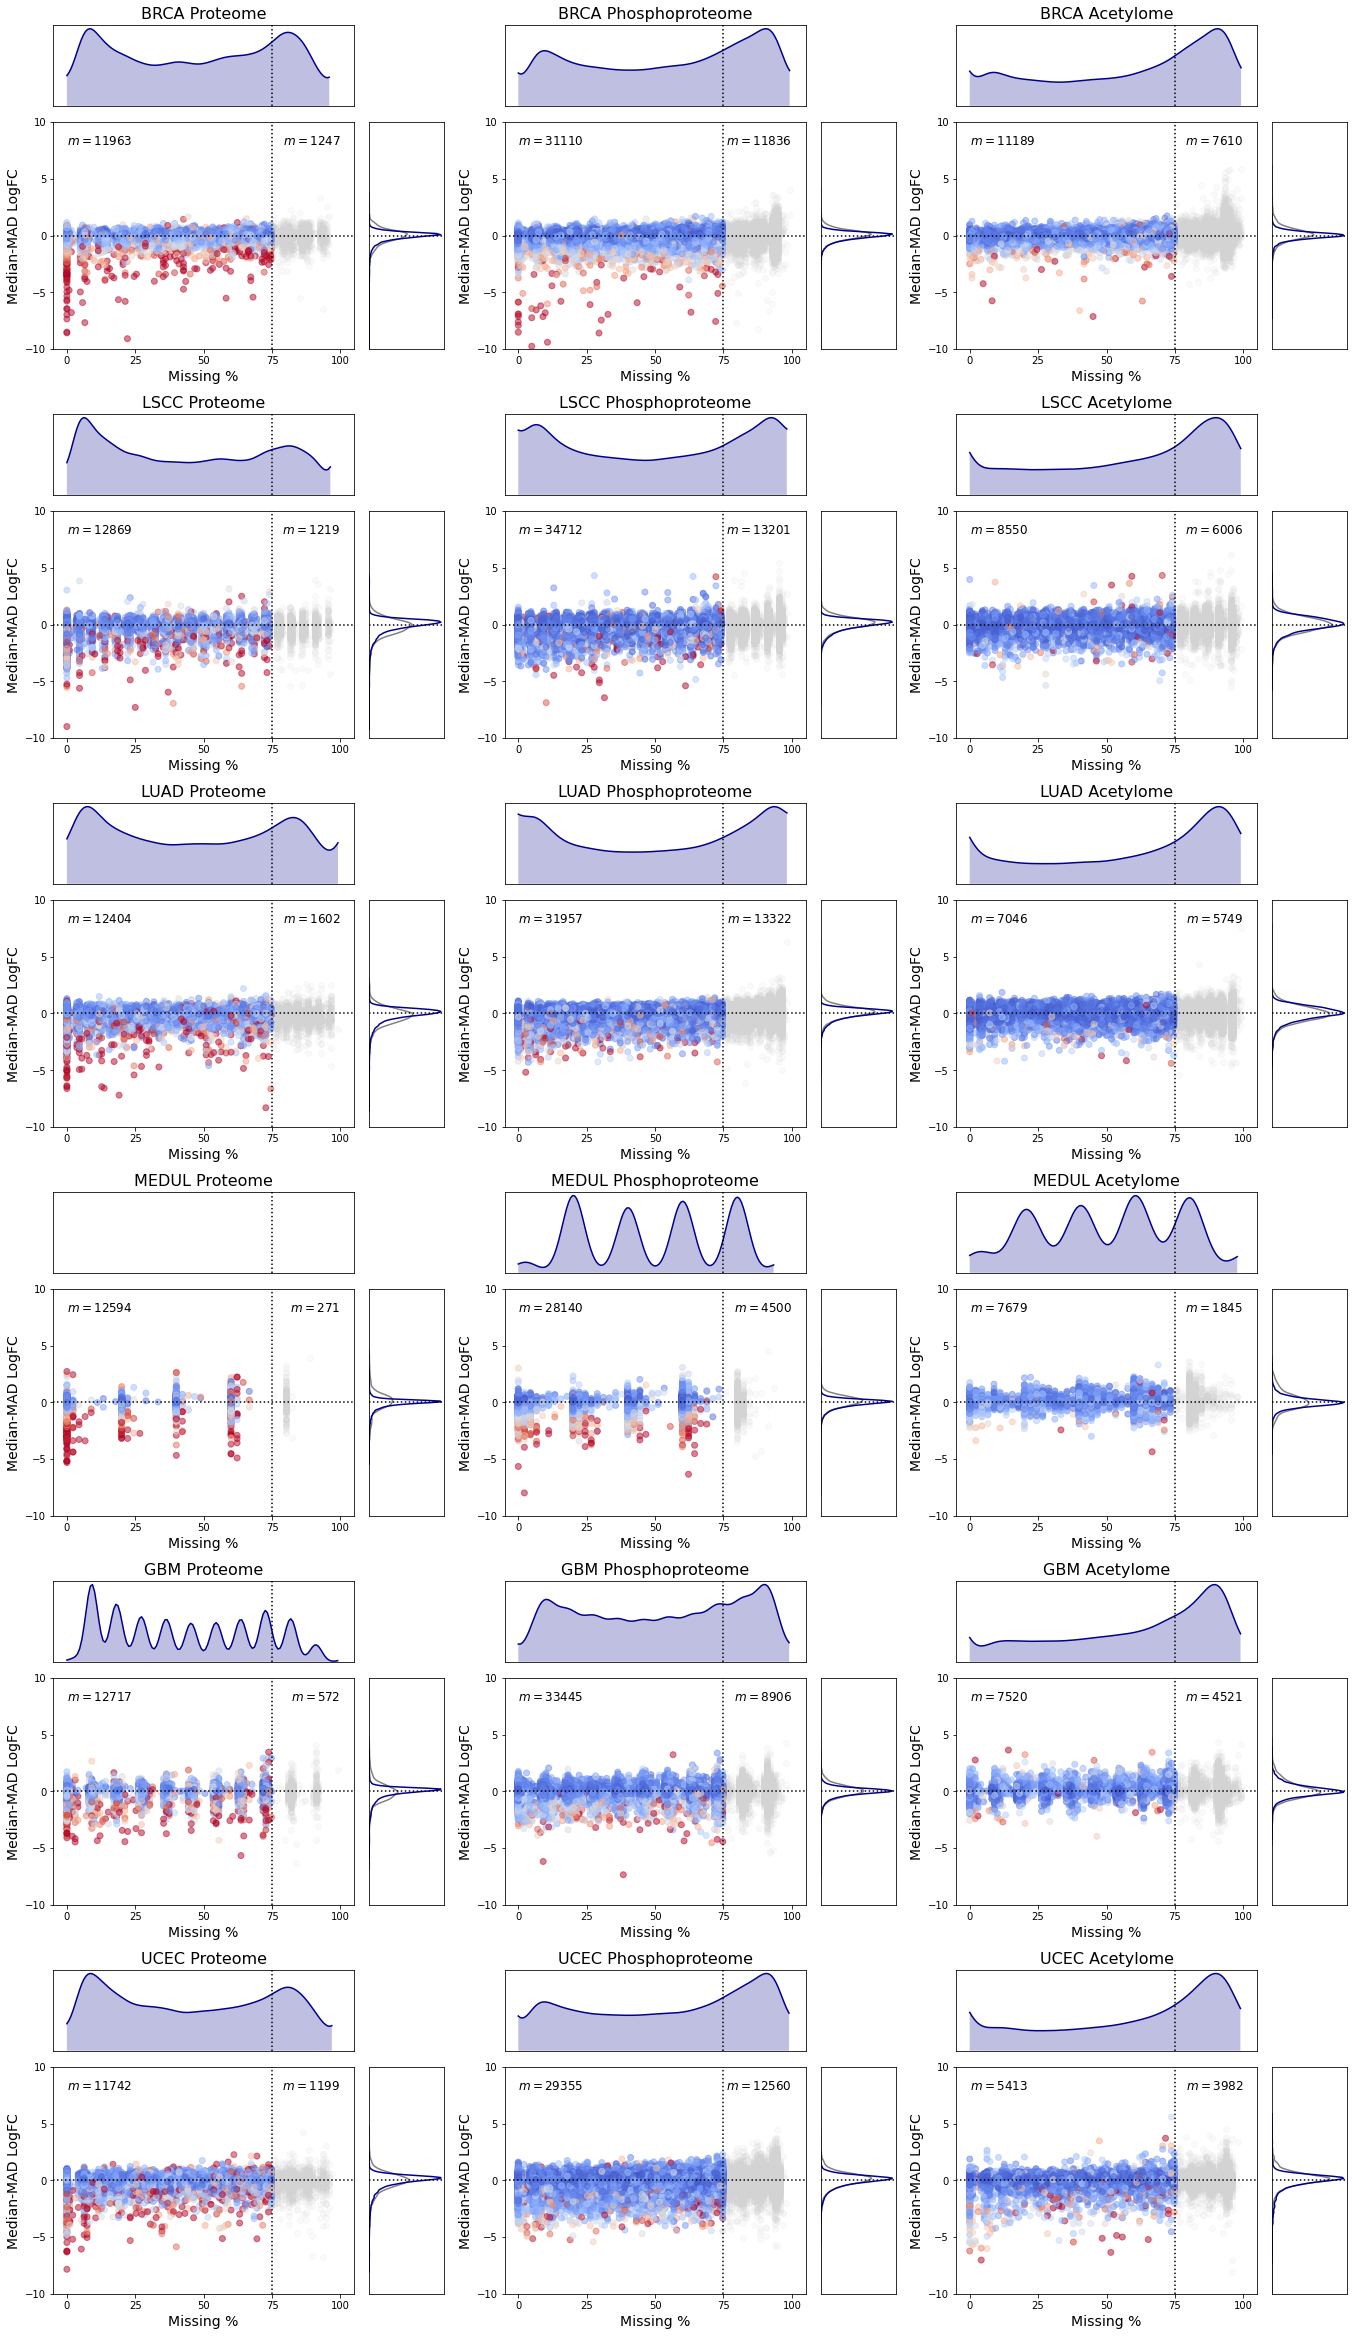

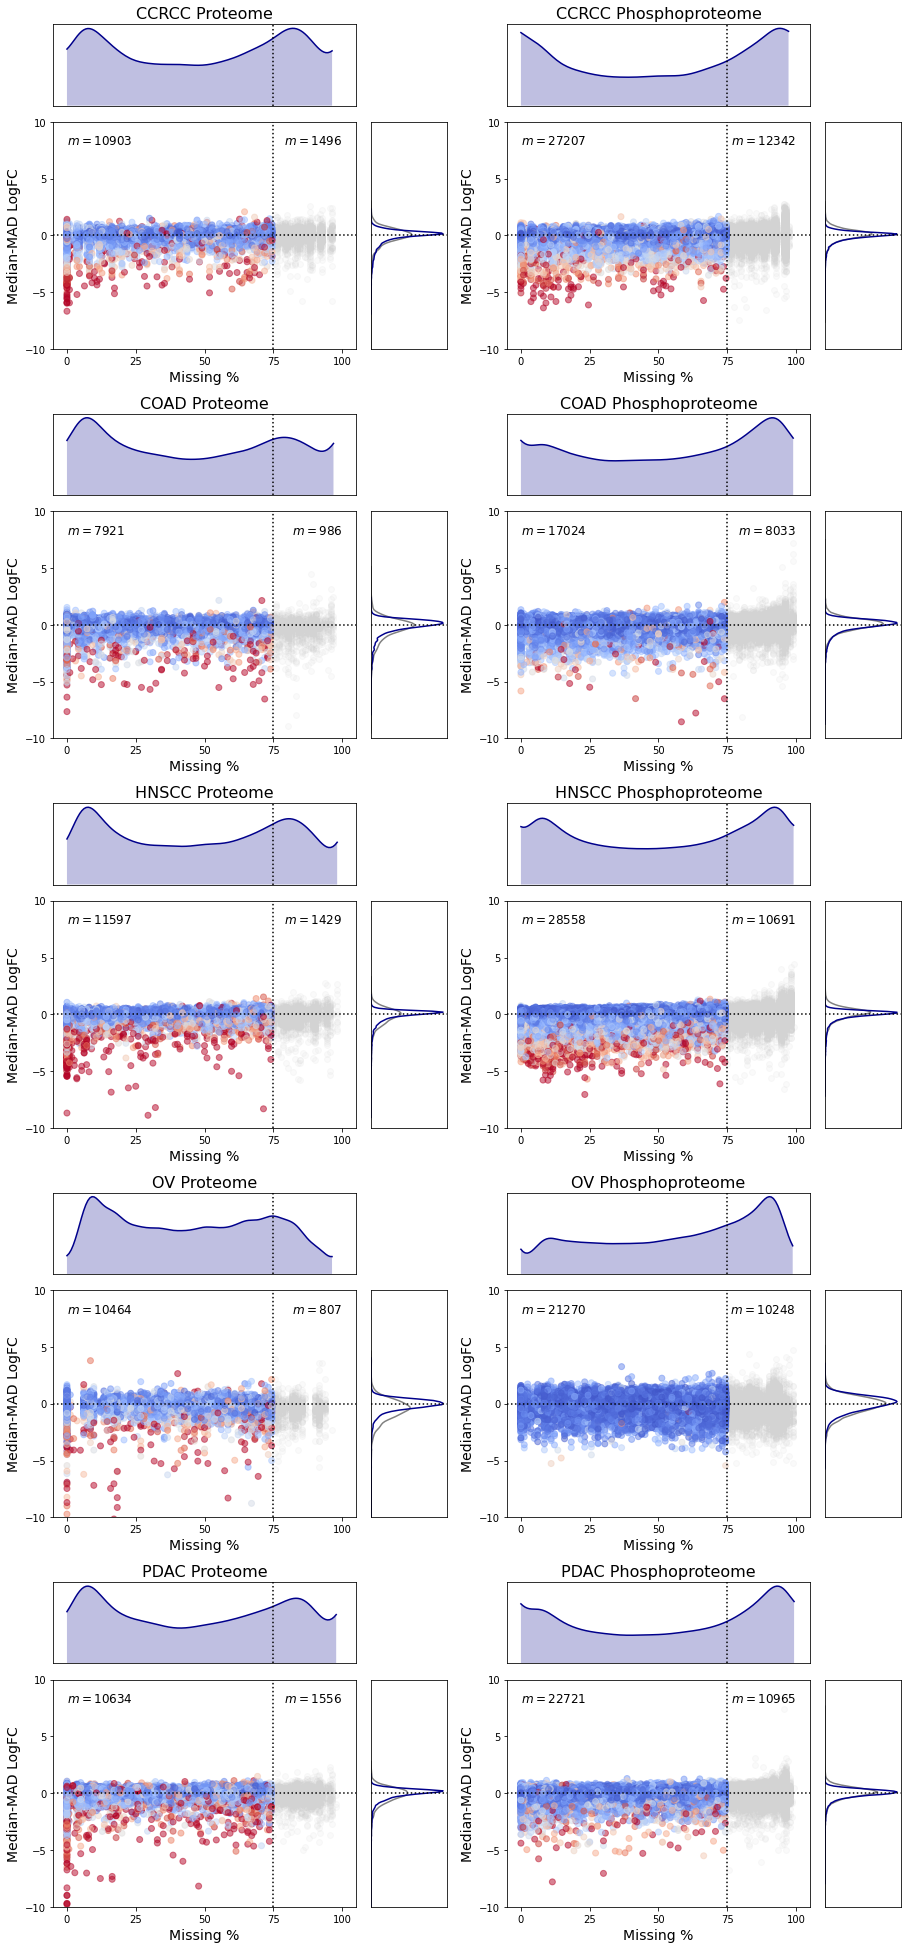

In [16]:
_aggr_1_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']),
    ['proteome','phosphoproteome','acetylome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_1.pdf"), dpi=100, bbox_inches='tight')

_aggr_2_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['CCRCC','COAD','HNSCC','OV','PDAC']),
    ['proteome','phosphoproteome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_2.pdf"), dpi=100, bbox_inches='tight')

In [17]:
_aggr_1_df += _aggr_2_df
aggr_df = pd.concat(_aggr_1_df)

In [18]:
intersecting_sites = {}

for assay in assays:
    gb = aggr_df[(aggr_df['assay']==assay) & (aggr_df['keep'])].reset_index().groupby('id').size()
    
    if assay=='acetylome':
        intersecting_sites[assay] = np.array(gb[gb==6].index)
    else:
        intersecting_sites[assay] = np.array(gb[gb==11].index)
        
    print("{} - {} intersecting sites".format(assay, intersecting_sites[assay].shape[0]))

proteome - 5716 intersecting sites
phosphoproteome - 4992 intersecting sites
acetylome - 2312 intersecting sites


In [19]:
cohorts = np.unique(samples_df['cohort'])

In [20]:
X = {}

assay = 'proteome'
X[assay] = pd.concat(
    [
        raw_data_files[assay][cohort]['All'] for
        cohort in 
        cohorts
    ],1
).T

assay = 'phosphoproteome'
X[assay] = pd.concat(
    [
        raw_data_files[assay][cohort]['All'] for
        cohort in 
        cohorts
    ],1
).T

assay = 'acetylome'
X[assay] = pd.concat(
    [
        raw_data_files[assay][cohort]['All'] for
        cohort in 
        ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']
    ],1
).T

In [21]:
print('--- Matrices ---')
pp.print_d(X)

# Save Raw-processed 
X['acetylome'].T.to_csv(os.path.join(OUT_DIR, "raw", "acetylome_X.tsv.gz"), sep='\t')
X['proteome'].T.to_csv(os.path.join(OUT_DIR, "raw", "proteome_X.tsv.gz"), sep='\t')
X['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "raw", "phosphoproteome_X.tsv.gz"), sep='\t')

--- Matrices ---
proteome: 1696 samples x 20742 features.
phosphoproteome: 1696 samples x 110274 features.
acetylome: 820 samples x 30239 features.


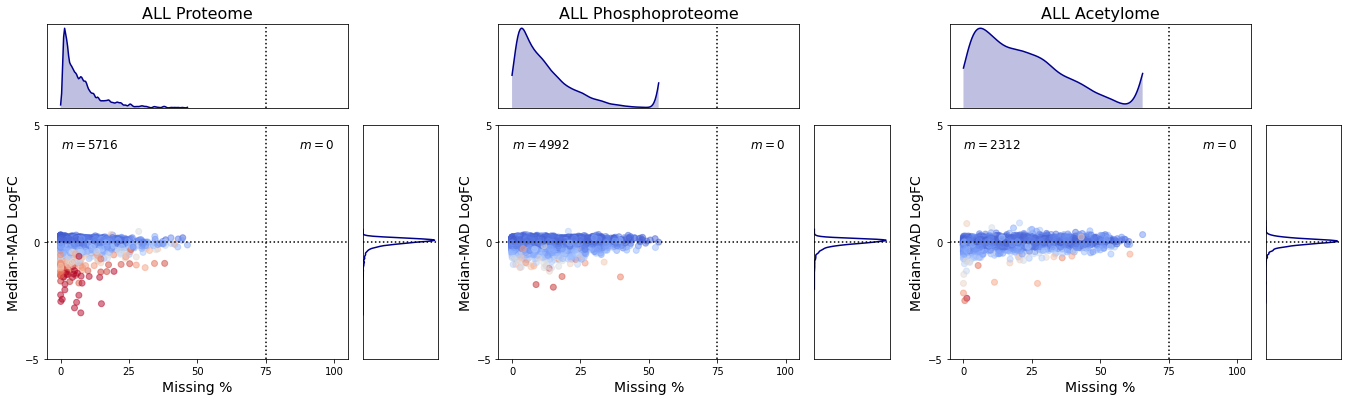

In [23]:
fig = plt.figure(figsize=(len(assays)*8,8))
gs = gridspec.GridSpec(9, 10*len(assays), hspace=0.5, wspace=0.5)

aggr_full_df = list()

lim=0.75

for col_idx,assay in enumerate(assays):
    idx = 0
    ax = plt.subplot(gs[(idx)*8+2:(idx+1)*8-1, 10*col_idx:(10*col_idx+7)])
    ax2 = plt.subplot(gs[(idx)*8+2:(idx+1)*8-1,(10*col_idx+7):(10*col_idx+9)])
    ax3 = plt.subplot(gs[(idx)*8:(idx)*8+2, 10*col_idx:(10*col_idx+7)])

    _aggr_df = pl.plot_prot_qc(
        X[assay].T.loc[intersecting_sites[assay]], 
        na_proportion_lim=lim, 
        title='ALL {}'.format(assay.capitalize()),
        axes=(ax,ax2,ax3),
        ylim=(-5,5)
        
    )
    ax.set_yticks([-5,0,5])
                
    _aggr_df['assay'] = assay
    aggr_full_df.append(_aggr_df)

aggr_full_df = pd.concat(aggr_full_df)
plt.savefig(os.path.join(PLOTS_DIR, "all_intersecting_grid_qc_plot.pdf"), dpi=100, bbox_inches='tight')

In [24]:
X_filt = dict()

X_filt['proteome'] = X['proteome'].loc[:,intersecting_sites['proteome']]
X_filt['phosphoproteome'] = X['phosphoproteome'].loc[:,intersecting_sites['phosphoproteome']]
X_filt['acetylome'] = X['acetylome'].loc[:,intersecting_sites['acetylome']]

In [25]:
print('--- Matrices ---')
pp.print_d(X_filt)

# Save na-filtered
X_filt['acetylome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "acetylome_X.tsv.gz"), sep='\t')
X_filt['proteome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "proteome_X.tsv.gz"), sep='\t')
X_filt['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "phosphoproteome_X.tsv.gz"), sep='\t')

--- Matrices ---
proteome: 1696 samples x 5716 features.
phosphoproteome: 1696 samples x 4992 features.
acetylome: 820 samples x 2312 features.


In [26]:
meta_s = samples_df[['cohort','Proteome_Sample_ID']].dropna().set_index("Proteome_Sample_ID")['cohort']
meta_n_s = samples_df[['cohort','Proteome_Normal_Sample_ID']].dropna().set_index("Proteome_Normal_Sample_ID")['cohort']

meta_s = pd.concat((pd.DataFrame(meta_s),pd.DataFrame(meta_n_s)))['cohort']

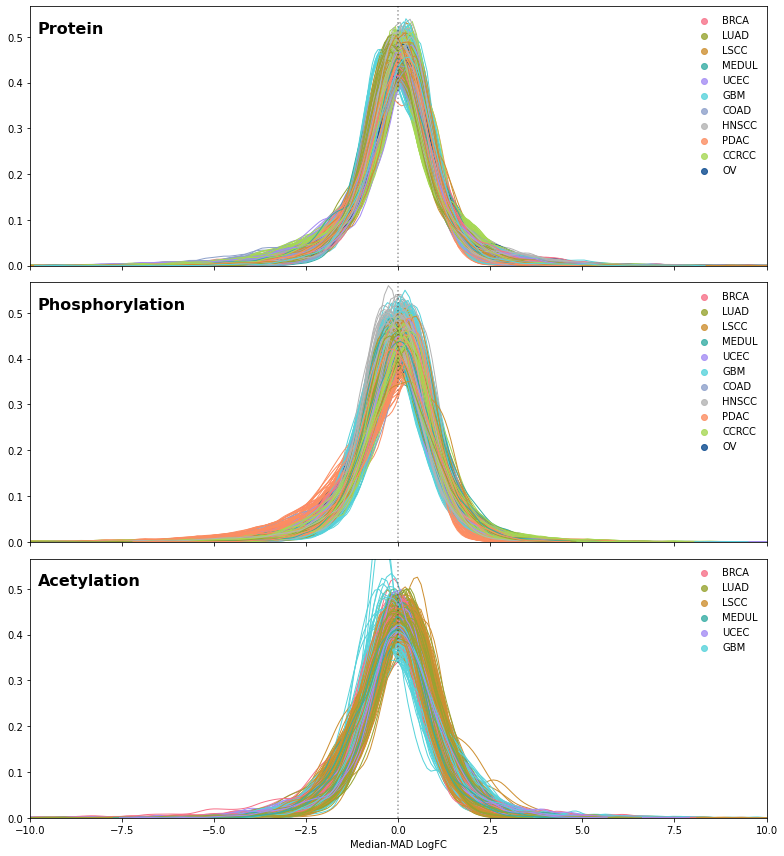

In [27]:
fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True, sharey=True)

pl.plot_sample_dist(X_filt['proteome'], meta_s, ax=axes[0], title='Protein')
pl.plot_sample_dist(X_filt['phosphoproteome'], meta_s, ax=axes[1], title='Phosphorylation')
pl.plot_sample_dist(X_filt['acetylome'], meta_s, ax=axes[2], title='Acetylation')

axes[2].set_xlabel("Median-MAD LogFC")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_sample_dist.pdf"), dpi=300, bbox_inches='tight')

## 4. Impute within Each Dataset

---

In [28]:
from sklearn.impute import KNNImputer

X_filt_i = {}

for assay in X_filt.keys():
    X_filt_i[assay] = list()
    
    if assay=='acetylome':
        _cohorts = ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']
    else:
        _cohorts = cohorts
    
    for cohort in _cohorts:
        cohort_s = meta_s[meta_s==cohort].index
        
        # Fit Imputer
        imputer = KNNImputer(n_neighbors=5)
        _X_i = pd.DataFrame(
            imputer.fit_transform(X_filt[assay].loc[cohort_s]), 
            index=cohort_s, 
            columns=X_filt[assay].columns
        )
        
        X_filt_i[assay].append(_X_i)
        
    X_filt_i[assay] = pd.concat(X_filt_i[assay])

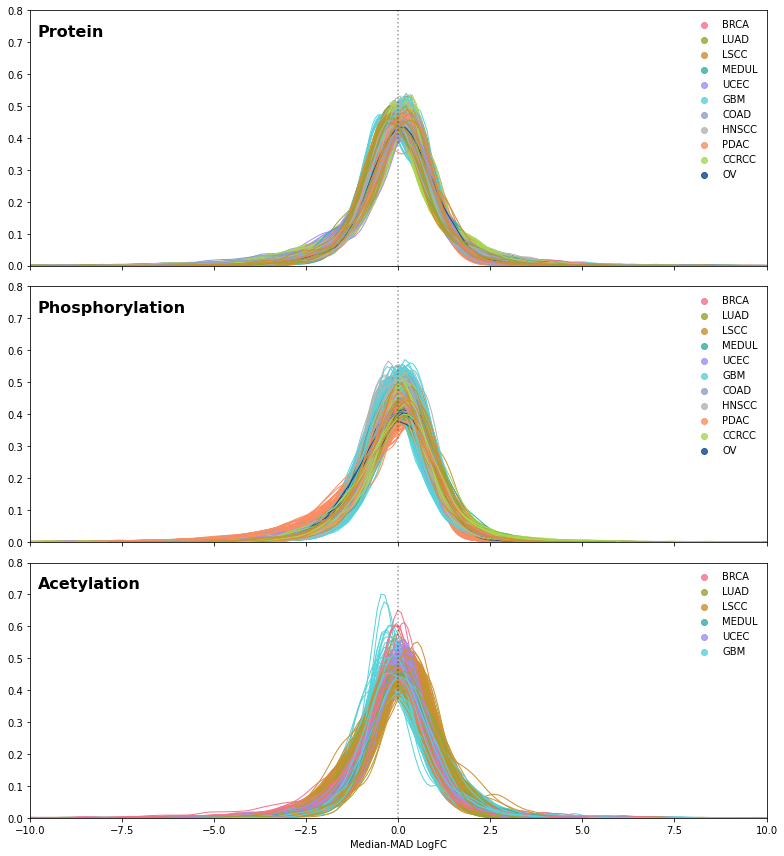

In [29]:
fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True)

pl.plot_sample_dist(X_filt_i['proteome'], meta_s, ax=axes[0], title='Protein')
pl.plot_sample_dist(X_filt_i['phosphoproteome'], meta_s, ax=axes[1], title='Phosphorylation')
pl.plot_sample_dist(X_filt_i['acetylome'], meta_s, ax=axes[2], title='Acetylation')

axes[0].set_ylim(0,0.8)
axes[1].set_ylim(0,0.8)
axes[2].set_ylim(0,0.8)
axes[2].set_xlabel("Median-MAD LogFC")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_i_sample_dist.pdf"), dpi=300, bbox_inches='tight')

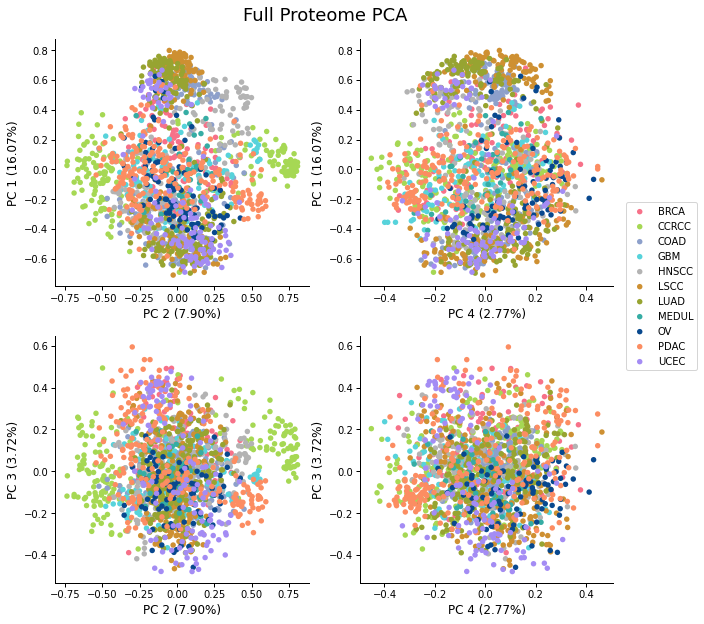

In [34]:
pl.plot_pca_grid(X_filt_i['proteome'].T, normalize=False, cohort_s=meta_s, cohort_colors=pl.CPTAC_CMAP, title='Full Proteome PCA')
plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_proteome_pca.pdf"), dpi=200, bbox_inches='tight')

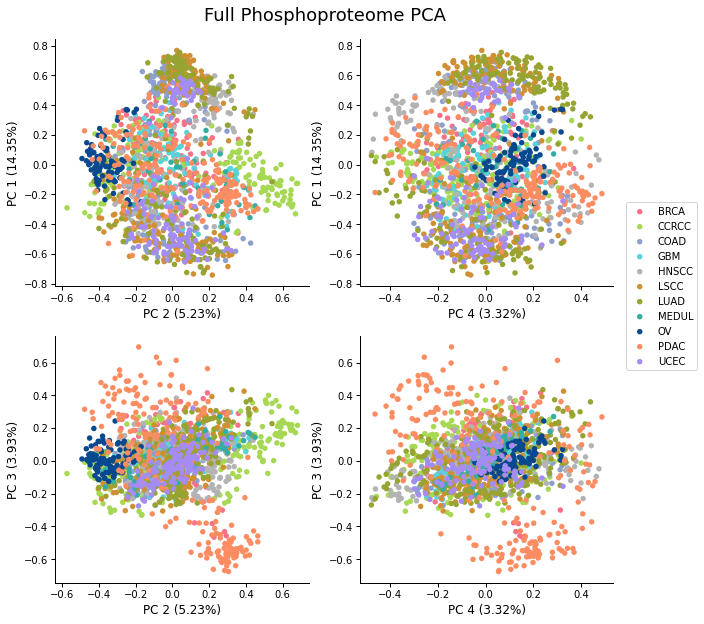

In [35]:
pl.plot_pca_grid(X_filt_i['phosphoproteome'].T, normalize=False, cohort_s=meta_s, cohort_colors=pl.CPTAC_CMAP, title='Full Phosphoproteome PCA')
plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_phosphoproteome_pca.pdf"), dpi=200, bbox_inches='tight')

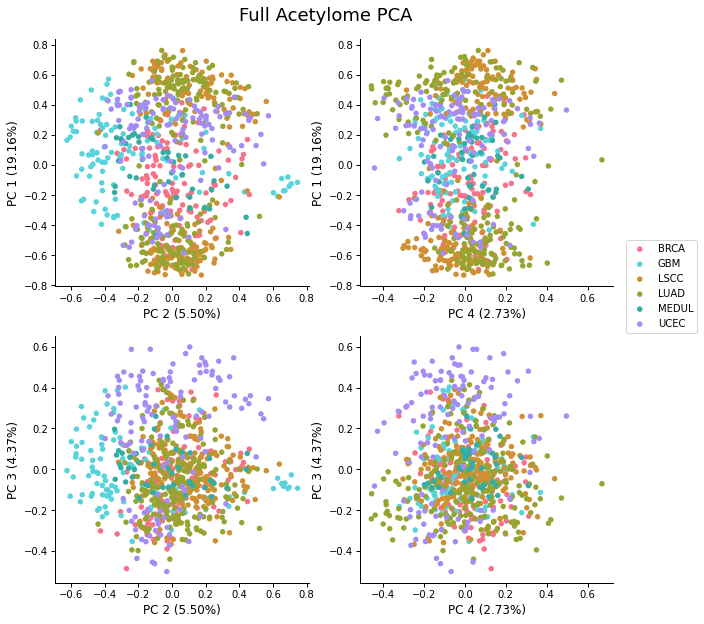

In [36]:
pl.plot_pca_grid(X_filt_i['acetylome'].T, normalize=False, cohort_s=meta_s, cohort_colors=pl.CPTAC_CMAP, title='Full Acetylome PCA')
plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_acetylome_pca.pdf"), dpi=200, bbox_inches='tight')

In [37]:
X_filt_i['acetylome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "acetylome_X.tsv.gz"), sep='\t')
X_filt_i['proteome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "proteome_X.tsv.gz"), sep='\t')
X_filt_i['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "phosphoproteome_X.tsv.gz"), sep='\t')

In [38]:
print("  * {} acetylomics sites\n  * {} proteomics sites\n  * {} phosphorylation sites".format(
    X_filt_i['acetylome'].shape[1],
    X_filt_i['proteome'].shape[1],
    X_filt_i['phosphoproteome'].shape[1]
))

  * 2312 acetylomics sites
  * 5716 proteomics sites
  * 4992 phosphorylation sites


## 5. Normalize PTM to Protein Levels

---

In [39]:
acetyl_samples = X_filt_i['acetylome'].index

In [40]:
df1,res1 = prot.fit_ptm_prot_ols(X_filt_i['phosphoproteome'].T, X_filt_i['proteome'].T, meta_s)
df2,res2 = prot.fit_ptm_prot_ols(X_filt_i['acetylome'].loc[acetyl_samples].T, X_filt_i['proteome'].loc[acetyl_samples].T, meta_s.loc[acetyl_samples])

Fitting OLS:   0%|          | 0/6 [00:00<?, ?it/s]

   * 3341 / 4992 sites with matching protein


Fitting OLS: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


   * 1889 / 2312 sites with matching protein


   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein


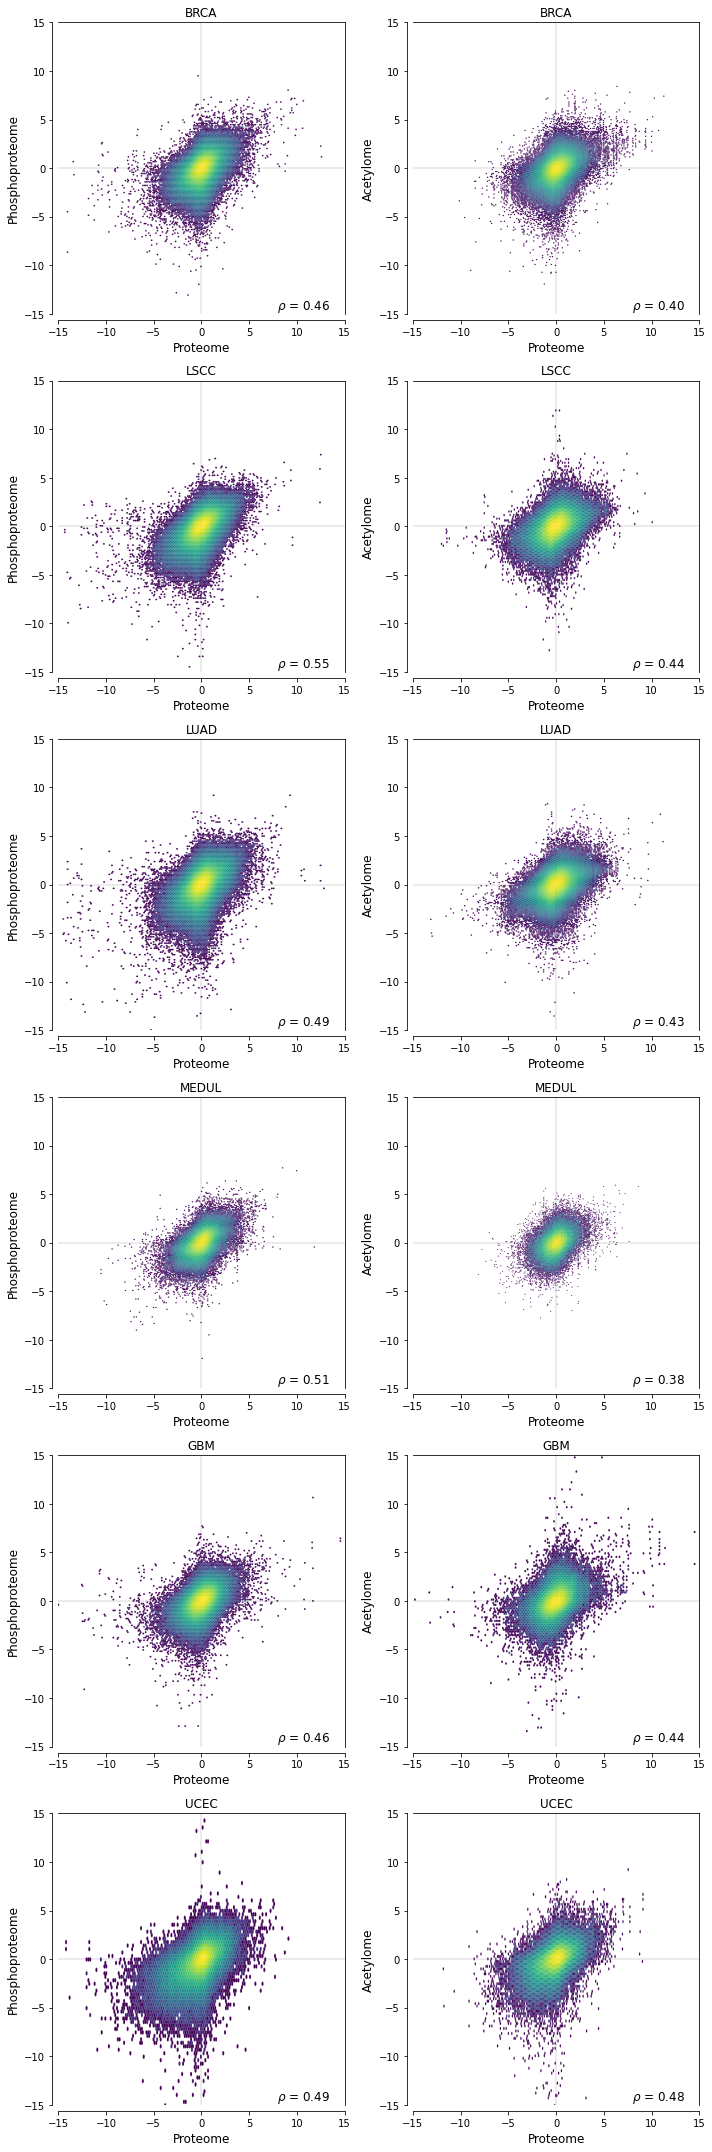

In [41]:
a_cohorts = np.array(['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC'])

fig,axes = plt.subplots(6,2,figsize=(10,30))

for i,cohort in enumerate(a_cohorts):
    pl.plot_ptm_prot_ols(
        X_filt_i['phosphoproteome'].T, 
        X_filt_i['proteome'].T, 
        meta_s, 
        cohort, 
        ax=axes[i,0], 
        l=15,
        plot_density=True
    )
    
    axes[i,0].set_title(cohort)
    axes[i,0].set_ylabel('Phosphoproteome')
    axes[i,0].set_xlabel('Proteome')
    
    pl.plot_ptm_prot_ols(
        X_filt_i['acetylome'].loc[acetyl_samples].T, 
        X_filt_i['proteome'].loc[acetyl_samples].T, 
        meta_s.loc[acetyl_samples], 
        cohort, 
        ax=axes[i,1], 
        l=15,
        plot_density=True
    )
    axes[i,1].set_title(cohort)
    axes[i,1].set_ylabel('Acetylome')
    axes[i,1].set_xlabel('Proteome')
    
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,"cohort_prot_ptm_1_fit.pdf"), dpi=100, bbox_inches='tight')

   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein


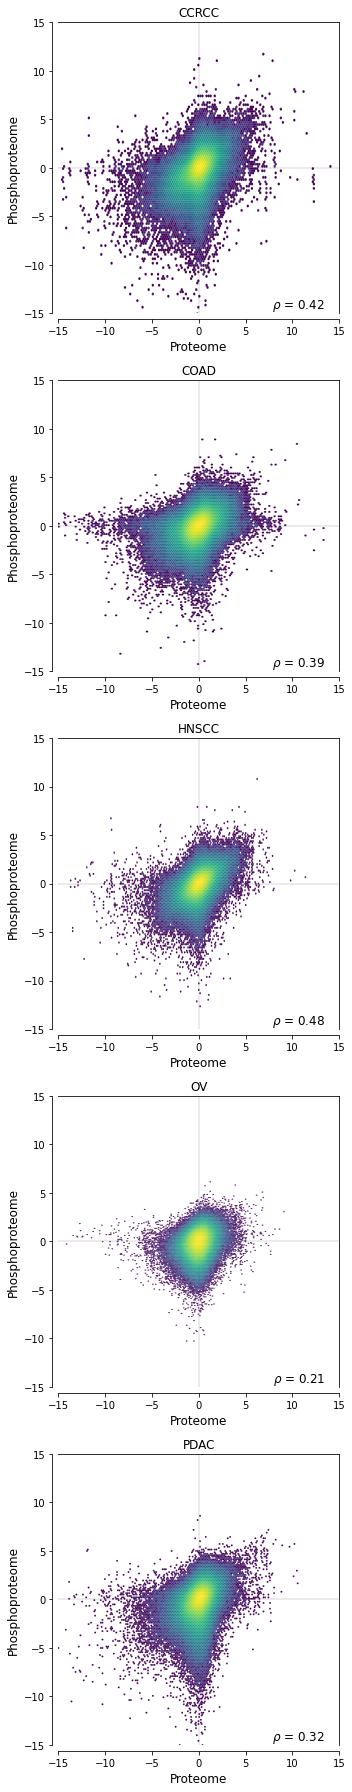

In [42]:
p_cohorts = np.array(['CCRCC','COAD','HNSCC','OV','PDAC'])

fig,axes = plt.subplots(5,1,figsize=(5,25))

for i,cohort in enumerate(p_cohorts):
    pl.plot_ptm_prot_ols(
        X_filt_i['phosphoproteome'].T, 
        X_filt_i['proteome'].T, 
        meta_s, 
        cohort, 
        ax=axes[i], 
        l=15,
        plot_density=True
    )
    
    axes[i].set_title(cohort)
    axes[i].set_ylabel('Phosphoproteome')
    axes[i].set_xlabel('Proteome')
    
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,"cohort_prot_ptm_2_fit.pdf"), dpi=100, bbox_inches='tight')

In [43]:
df1.to_csv(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_ols_filt.tsv.gz"))
df2.to_csv(os.path.join(OUT_DIR, "imputed_res", "acetylome_ols_filt.tsv.gz"))

phosph_res = pd.pivot(df1.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')
acetyl_res = pd.pivot(df2.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')

phosph_res.to_parquet(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_X.parquet"))
acetyl_res.to_parquet(os.path.join(OUT_DIR, "imputed_res", "acetylome_X.parquet"))
X_filt_i['proteome'].T.to_parquet(os.path.join(OUT_DIR, "imputed_res", "proteome_X.parquet"))

phosph_res.to_csv(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_X.tsv.gz"),sep='\t')
acetyl_res.to_csv(os.path.join(OUT_DIR, "imputed_res", "acetylome_X.tsv.gz"),sep='\t')
X_filt_i['proteome'].T.to_csv(os.path.join(OUT_DIR, "imputed_res", "proteome_X.tsv.gz"),sep='\t')

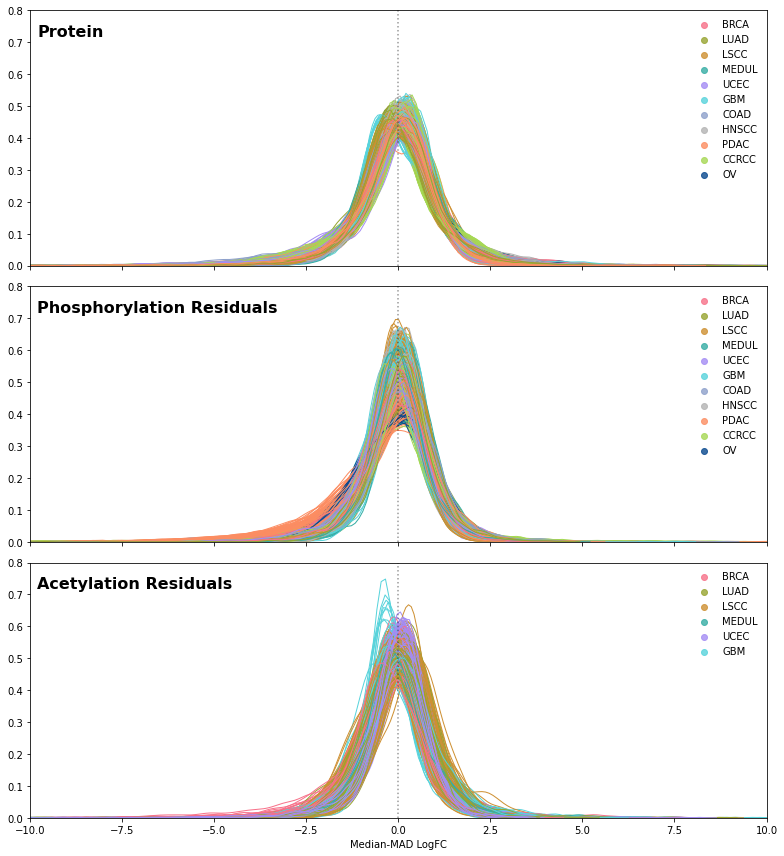

In [44]:
fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True)

pl.plot_sample_dist(X_filt_i['proteome'], meta_s, ax=axes[0], title='Protein')
pl.plot_sample_dist(phosph_res.T, meta_s, ax=axes[1], title='Phosphorylation Residuals')
pl.plot_sample_dist(acetyl_res.T, meta_s, ax=axes[2], title='Acetylation Residuals')

axes[0].set_ylim(0,0.8)
axes[1].set_ylim(0,0.8)
axes[2].set_ylim(0,0.8)
axes[2].set_xlabel("Median-MAD LogFC")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_i_res_sample_dist.pdf"), dpi=300, bbox_inches='tight')